# 10.2 Modele generatywne: GANy

W tym skrypcie znajdziemy wyniki eksperymentów opisanych w rozdziale 10.2 ,,Modele generatywne: GANy'', które dotyczą sieci generatywnych GAN.


### Importowanie niezbędnych modułow

In [82]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm


print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)

PyTorch: 1.10.0
Torchvision: 0.11.1


Klasa ,,*AverageMeter*'' przechowuje oraz przetwarza częściowe wyniki zapisywane w poszczegółnych etapach uczenia modelu. Funkcja ,,*count_parameters*'' zlicza liczbę parametrów sieci, zaś funkcja ,,*show*'' rysuje obrazki ze zbioru danych i ich rekonstrukcje.

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=2.5)
sns.set_style("whitegrid")


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum = self.sum + val * n
        self.count = self.count + n
        self.avg = self.sum / self.count


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def show(img, recon_img, num_col=None, title=None):
    if recon_img is None:
        rec_images = img
    else:
        n = img.shape[0]
        assert n >= num_col
        rec_images = torch.empty((2 * num_col, 3, 32, 32))
        rec_images.data[:num_col] = img.data[:num_col]
        rec_images.data[num_col:] = recon_img.data[:num_col]

    plt.figure(figsize=[16, 8])
    if title:
        plt.title(title)
    grid = torchvision.utils.make_grid(
        rec_images, nrow=num_col, padding=1, normalize=True, scale_each=True
    )
    np_grid = grid.cpu().numpy()
    plt.axis("off")
    plt.imshow(np.transpose(np_grid, (1, 2, 0)), interpolation="nearest")

# Dataloader

W tej części przygotowujemy zbiór danych do trenowania i walidacji modelu. Przetwarzamy obrazki ze zbioru *MNIST* do tensorów, które są pobierane iteracyjnie w batchach podczas trenowania sieci (zmienne: ,,*train_loader*'', ,,*test_loader*'').

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = torchvision.datasets.MNIST(
    root="/datasets", download=False, train=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=False
)

test_dataset = torchvision.datasets.MNIST(
    root="/datasets", download=False, train=False, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=4, pin_memory=False
)

device=device(type='cuda')


# DCGAN

Poniżej definujemy klasy: ,,Generator'', ,,Discriminator'', które są częścią generatywnej sieci DC-GAN. Sieć bazuje na warstwach konwolucyjnych. 

In [85]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


class Generator(torch.nn.Module):
    def __init__(
        self, num_output_channel: int = 1, dim_z: int = 100, dim_h: int = 64
    ) -> None:
        super(Generator, self).__init__()

        self.net = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(dim_z, dim_h * 8, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(dim_h * 8),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(dim_h * 8, dim_h * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(dim_h * 4),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(dim_h * 4, dim_h * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(dim_h * 2),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(dim_h * 2, dim_h, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(dim_h),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(dim_h, num_output_channel, 1, 1, 2, bias=False),
            torch.nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class Discriminator(torch.nn.Module):
    def __init__(self, num_output_channel: int = 1, dim_h: int = 64) -> None:
        super(Discriminator, self).__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(num_output_channel, dim_h, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(dim_h, dim_h * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(dim_h * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(dim_h * 2, dim_h * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(dim_h * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(dim_h * 4, 1, 4, 2, 1, bias=False),
            torch.nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self.net(x)
        return output.view(-1, 1).squeeze(1)

Uczenie modelu i jego walidacja.

In [ ]:
num_output_channel = 1
dim_z = 8  # 100
dim_h = 20  # 64
dim_hd = 24  # 64

netG = Generator(num_output_channel, dim_z, dim_h).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(num_output_channel, dim_hd).to(device)
netD.apply(weights_init)
print(netD)

print(f"Number of parameters of Generator: {count_parameters(netG)}")
print(f"Number of parameters of Discriminator: {count_parameters(netD)}")

criterion = torch.nn.BCELoss()

lr = 0.0002
beta1 = 0.5

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


scores = {"lossG": [], "lossD": [], "D_x": [], "D_G_z1": [], "D_G_z2": []}

fixed_noise = torch.randn(20, dim_z, 1, 1, device=device)

real_label = 1.0
fake_label = 0.0

# training
netG.train()
netD.train()

epochs = 25
pbar = tqdm(range(epochs), leave=True)
for epoch in pbar:

    loss_G = AverageMeter()
    loss_D = AverageMeter()
    D_x = AverageMeter()
    D_G_z1 = AverageMeter()
    D_G_z2 = AverageMeter()

    train_tqdm = tqdm(train_loader, total=len(train_loader), leave=False)
    for image, _ in train_tqdm:
        image = image.to(device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()

        label = torch.full(
            (image.shape[0],), real_label, dtype=torch.float, device=device
        )

        output = netD(image).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x.update(output.mean().item())

        noise = torch.randn(image.shape[0], dim_z, 1, 1, device=device)

        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()

        D_G_z1.update(output.mean().item())

        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)

        errG.backward()
        D_G_z2.update(output.mean().item())
        optimizerG.step()

        loss_G.update(errG.item())
        loss_D.update(errD.item())

        train_tqdm.set_description(
            f"Loss_D: {loss_D.val:.4g} ({loss_D.avg:.4g}); "
            f"Loss_G: {loss_G.val:.4g} ({loss_G.avg:.4g}); "
            f"D(x): {D_x.val:.4g} ({D_x.avg:.4g}); "
            f"D(G(z)): {D_G_z1.val / D_G_z2.val:.4g} ({D_G_z1.avg / D_G_z2.avg:.4g})"
        )

        scores["lossG"].append(loss_G.avg)
        scores["lossD"].append(loss_D.avg)
        scores["D_x"].append(D_x.avg)
        scores["D_G_z1"].append(D_G_z1.avg)
        scores["D_G_z2"].append(D_G_z2.avg)
    pbar.set_description(
        f"Loss_D: {scores['lossD'][-1]:.4g}; Loss_G: {scores['lossG'][-1]:.4g}; "
        f"D(x): {scores['D_x'][-1]:.4g}; "
        f"D(G(z)): {scores['D_G_z1'][-1] / scores['D_G_z2'][-1]:.4g}"
    )

    if epoch % 5 == 0 or epoch == epochs - 1:
        with torch.no_grad():
            imgs = netG(fixed_noise).detach().cpu()
            show(imgs, None, 10, title=f"{epoch=}")
            plt.pause(0.1)


torch.save(
    netG.state_dict(), "netG.pth"
)  # zapisujemy model generatywny do dalszej ewaluacji
# torch.save(netD.state_dict(), "netD.pth")

Poniżej przedstawiamy zmianę funkcji kosztu dla części generatywnej i dyskryminującej model DC-GAN.

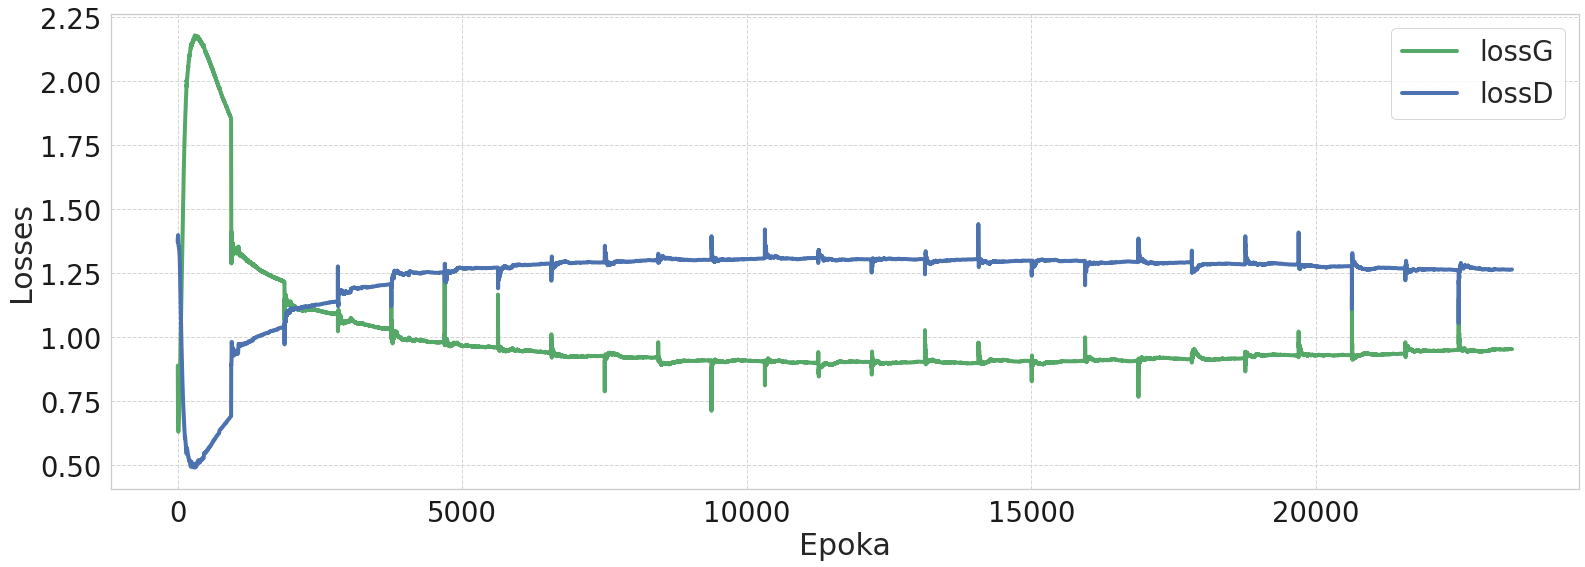

In [89]:
# loss
fig = plt.figure(figsize=(22, 8))
ax = fig.add_subplot(111)
ax.plot(scores["lossG"], "g-", linewidth=4, markersize=12, label="lossG")
ax.plot(scores["lossD"], "b-", linewidth=4, markersize=12, label="lossD")
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.legend(loc=0)
ax.set_ylabel("Losses")
ax.set_xlabel("Epoka")
plt.tight_layout(pad=0.5)

plt.show()
plt.close()

Przykładowe obrazki jakie zostały wygenerowanie poprzez wylosowanie z rozkładu $\mathcal{N}(0,1)$ kilku wektorów z przestrzeni latent (szum) i przepuszczenie ich przez generator. 

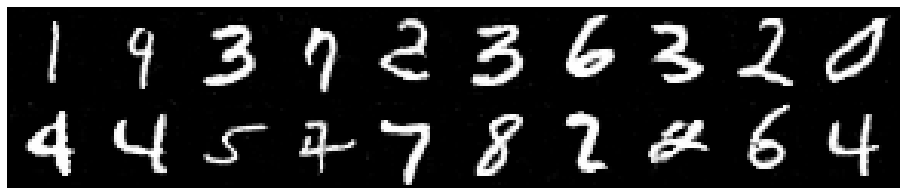

In [90]:
# generation
netG.eval()

with torch.no_grad():
    z = torch.randn(20, dim_z, 1, 1, device=device)
    imgs = netG(z)
    show(imgs, None, 10)

plt.close("all")

W celu policzenia *FID score* zapiszemy w jednym folderze obrazki pochodzące ze zbioru walidującego MNIST, zaś w drugim folderze losowo generujemy taką samą liczbę obrazków z wyuczonego modelu DC-GAN (do tego używamy generatora).  

In [ ]:
from PIL import Image


# num_output_channel = 1
# dim_z = 8  # 100
# dim_h = 16  # 64

netG = Generator(num_output_channel, dim_z, dim_h).to(device)
netG.load_state_dict(torch.load("netG.pth"))
print(netG)


total_imgs = 10000


Path("orig_mnist_test").mkdir(parents=True, exist_ok=True)
if not any(Path("orig_mnist_test").iterdir()):
    n = 0
    eval_tqdm = tqdm(enumerate(test_loader), total=len(test_loader))
    for i, (image, _) in eval_tqdm:
        if n >= total_imgs:
            break
        image = image.to(device)

        for i in range(image.shape[0]):
            grid = torchvision.utils.make_grid(
                image[i], nrow=1, padding=0, normalize=True, scale_each=True
            )
            np_grid = grid.cpu().numpy()
            img = (np.transpose(np_grid, (1, 2, 0)) * 255).astype(np.uint8)
            im = Image.fromarray(img)
            im.save(f"orig_mnist_test/{n + i}.png")

        n += image.shape[0]


Path("dcgan_mnist").mkdir(parents=True, exist_ok=True)

if not any(Path("dcgan_mnist").iterdir()):
    netG.eval()

    with torch.no_grad():
        for i in tqdm(range(total_imgs)):
            z = torch.randn(1, dim_z, 1, 1, device=device)
            img = netG(z)

            grid = torchvision.utils.make_grid(
                img, nrow=1, padding=0, normalize=True, scale_each=True
            )
            np_grid = grid.cpu().numpy()
            img = (np.transpose(np_grid, (1, 2, 0)) * 255).astype(np.uint8)
            im = Image.fromarray(img)
            im.save(f"dcgan_mnist/{i}.png")

Teraz policzymy *FID score* podając ścieżki do obrazków oryginalnych i wygenerowanych przez wyuczoną sieć DC-GAN.

In [94]:
import fid_score


device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
num_workers = 4
dims = 2048
paths = ["dcgan_mnist", "orig_mnist_test"]
batch_size = 100

fid_value = fid_score.calculate_fid_given_paths(
    paths, batch_size, device, dims, num_workers
)
print("FID: ", fid_value)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.54it/s]


FID:  15.38291690332423
